/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_2828/98378448.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])


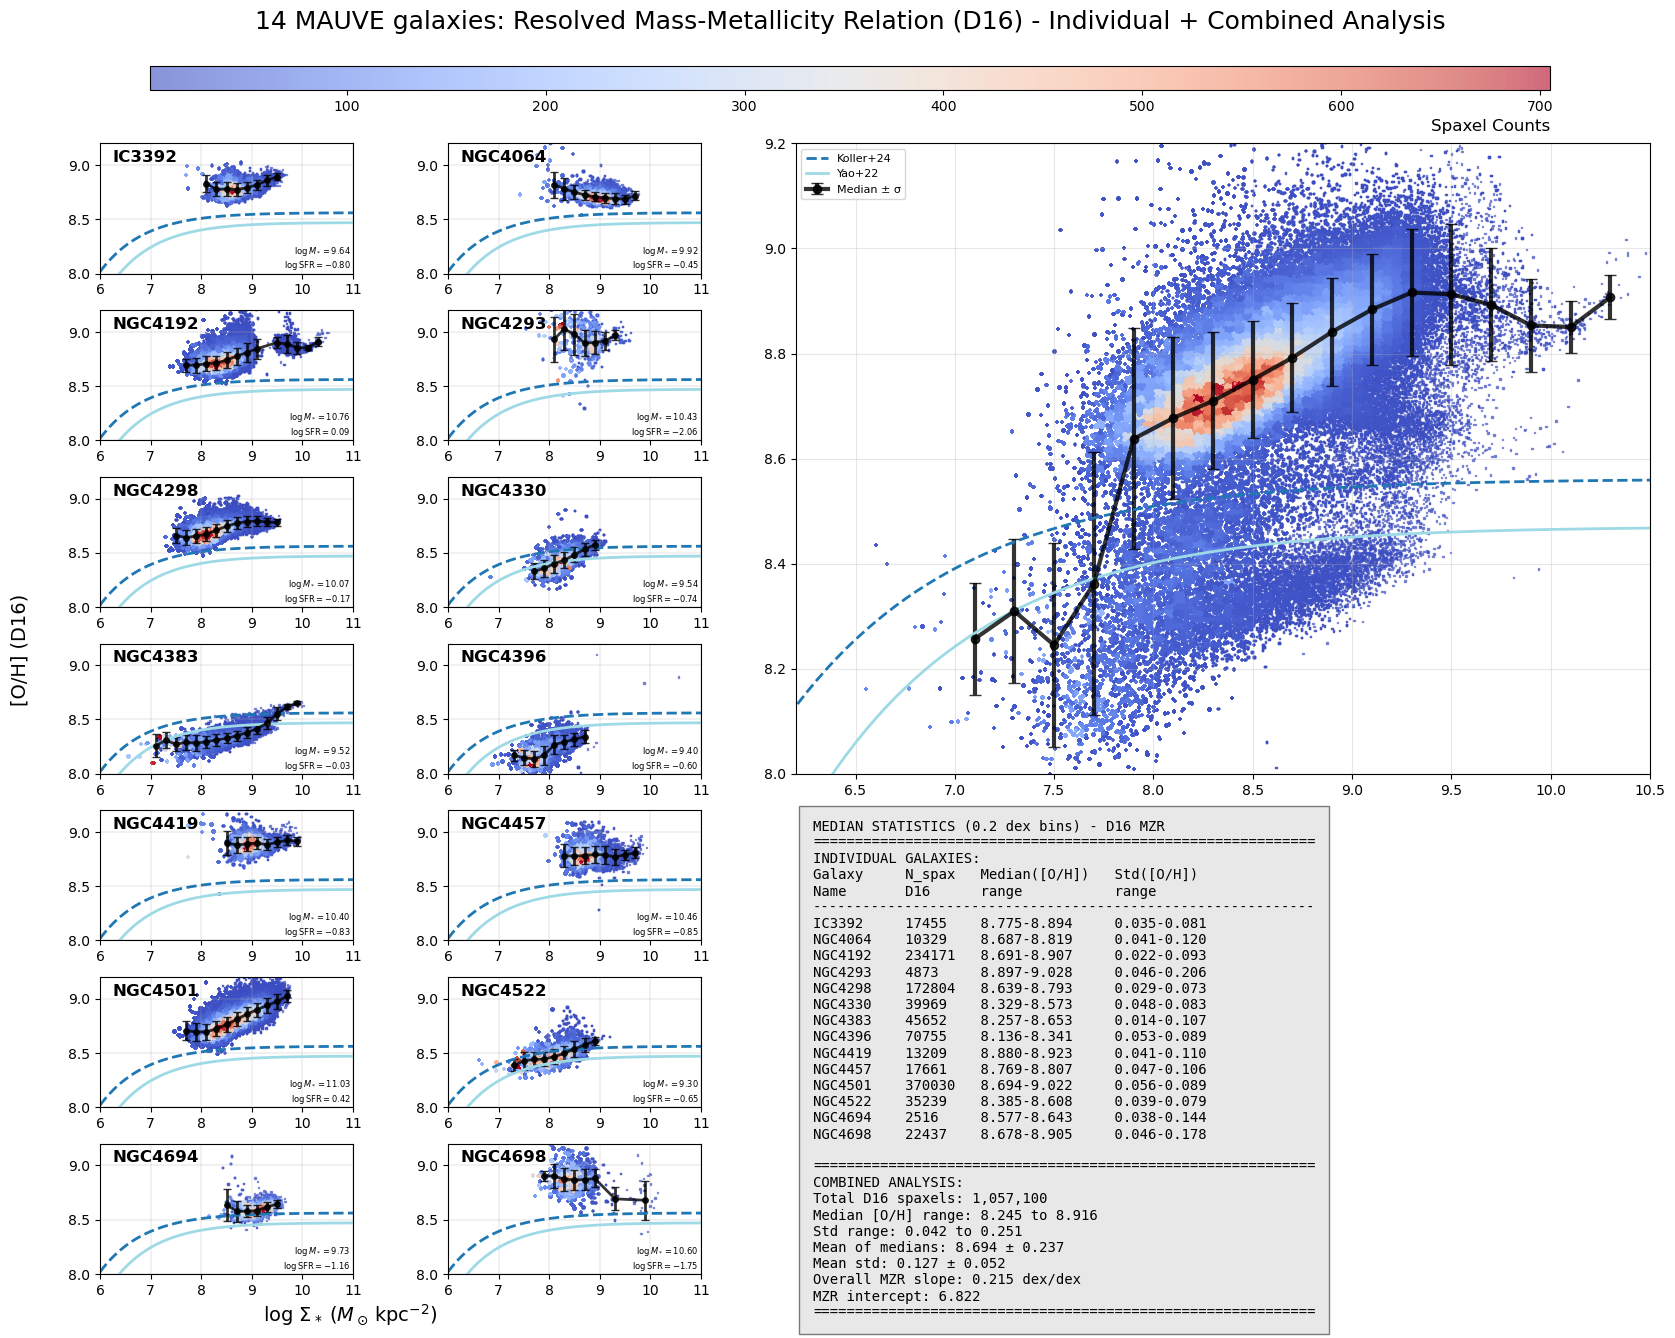

In [1]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (D16 MZR)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        oh_d16 = h['O_H_D16_SF'].data
    return sigM, oh_d16

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR from SF region:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2
    
    medians = []
    stds = []
    x_valid = []
    
    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])
    
    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color=colors[i])
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color=colors[i])

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
scatter_for_cbar = None
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    sigM, oh_d16 = load_maps(gal)
    
    good_d16 = np.isfinite(sigM) & np.isfinite(oh_d16)
    
    if not np.any(good_d16):
        print(f"Skipping {gal}: no valid data points")
        continue
    
    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])
    
    x_d16, y_d16 = sigM[good_d16], oh_d16[good_d16]
    
    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_d16, y_d16)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_d16)))
    
    # Density-based scatter
    H, xedges, yedges = np.histogram2d(x_d16, y_d16, bins=50, range=[[6, 11], [8.0, 9.2]])
    x_idx = np.clip(np.digitize(x_d16, xedges) - 1, 0, H.shape[0] - 1)
    y_idx = np.clip(np.digitize(y_d16, yedges) - 1, 0, H.shape[1] - 1)
    density = H[x_idx, y_idx]
    
    scatter = axP.scatter(x_d16, y_d16, c=density, s=1, alpha=0.6, marker=',', 
                         cmap='coolwarm')
    
    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2, 
                    markersize=4, capsize=3, alpha=0.8)
    
    if scatter_for_cbar is None:
        scatter_for_cbar = scatter
    
    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)
    
    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))
    
    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)
    
    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))
    
    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)
    axP.grid(True, lw=0.25)

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y = [], []
galaxy_counts = {}

for gal in galaxies:
    sigM, oh_d16 = load_maps(gal)
    good_d16 = np.isfinite(sigM) & np.isfinite(oh_d16)
    
    if np.any(good_d16):
        x_d16, y_d16 = sigM[good_d16], oh_d16[good_d16]
        all_x.extend(x_d16)
        all_y.extend(y_d16)
        galaxy_counts[gal] = len(x_d16)
    else:
        galaxy_counts[gal] = 0

all_x, all_y = np.array(all_x), np.array(all_y)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Density-based scatter for combined data
H, xedges, yedges = np.histogram2d(all_x, all_y, bins=100, range=[[6, 11], [8.0, 9.2]])
x_idx = np.clip(np.digitize(all_x, xedges) - 1, 0, H.shape[0] - 1)
y_idx = np.clip(np.digitize(all_y, yedges) - 1, 0, H.shape[1] - 1)
density = H[x_idx, y_idx]

scatter_combined = ax_combined.scatter(all_x, all_y, c=density, s=1, alpha=0.6, marker=',', 
                                      cmap='coolwarm')

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined, 
                        fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font
ax_combined.legend(fontsize=8, ncol=1, loc='upper left')

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)
ax_combined.grid(True, alpha=0.3)

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - D16 MZR\n"
stats_table += "="*60 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<15} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'D16':<8} {'range':<15} {'range':<15}\n"
stats_table += "-"*60 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<15} {std_range:<15}\n"

stats_table += "\n" + "="*60 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total D16 spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"
    
    # Calculate overall metallicity gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"
        
stats_table += "="*60

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=10, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Add horizontal colorbar at the top
if scatter_for_cbar is not None:
    cbar_ax = fig.add_axes([0.15, 0.85, 0.7, 0.015])
    cbar = plt.colorbar(scatter_for_cbar, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Spaxel Counts', fontsize=12, loc='right')

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (D16) - Individual + Combined Analysis', 
             fontsize=18, y=0.90)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', 
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'[O/H] (D16)', 
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

In [2]:
# -----------------------------------------------
# Energy k-sample (E-ANOVA) test for rMZR (D16)
# -----------------------------------------------
import numpy as np
from sklearn.metrics import pairwise_distances


def _zscore(X):
    mu = X.mean(axis=0)
    sig = X.std(axis=0)
    sig[sig == 0] = 1.0
    return (X - mu) / sig


def collect_groups_for_energy_test(
    galaxy_names,
    xlim=(6.0, 11.0),
    ylim=(8.0, 9.2),
    standardize=True,
    max_per_group=400,
    rng_seed=42
):
    """Return (groups, names) where each group is an (n_i,2) array of
    [logΣ*, 12+log(O/H)_D16] spaxels within the provided window.
    """
    rng = np.random.default_rng(rng_seed)
    raw_groups, names = [], []

    # 1) gather raw points per galaxy, clip to common window
    for gal in galaxy_names:
        sigM, oh_d16 = load_maps(gal)
        m = np.isfinite(sigM) & np.isfinite(oh_d16)
        if not np.any(m):
            continue
        x, y = sigM[m], oh_d16[m]
        clip = (x >= xlim[0]) & (x <= xlim[1]) & (y >= ylim[0]) & (y <= ylim[1])
        x, y = x[clip], y[clip]
        if x.size == 0:
            continue
        XY = np.column_stack([x, y])

        # Subsample to cap memory / runtime
        if XY.shape[0] > max_per_group:
            idx = rng.choice(XY.shape[0], size=max_per_group, replace=False)
            XY = XY[idx]

        raw_groups.append(XY)
        names.append(gal)

    if len(raw_groups) < 2:
        raise ValueError("Need data from at least two galaxies.")

    # 2) (optional) standardize pooled data so axes are comparable
    if standardize:
        pooled = np.vstack(raw_groups)
        pooled_z = _zscore(pooled)
        # write back the standardized values in the same splits
        groups, start = [], 0
        for XY in raw_groups:
            n = XY.shape[0]
            groups.append(pooled_z[start:start+n])
            start += n
    else:
        groups = raw_groups

    return groups, names


def energy_anova_k_sample(groups, reps=2000, alpha=1.0, random_state=42, dtype=np.float32, verbose=True):
    """
    Multi-sample energy test (Szekely & Rizzo) with permutation p-value.

    E-statistic:
      E = sum_{i<j} (n_i n_j / N) * ( 2*δ_ij - δ_ii - δ_jj )
    where δ_ij is the average pairwise distance^alpha between groups i and j
    and δ_ii is the average *within* group i (off-diagonal).

    Returns
    -------
    stat_obs : float
        Observed E statistic.
    p_value : float
        Permutation p-value (>= observed).
    info : dict
        Extra details (group sizes, null distribution summary, etc.).
    """
    rng = np.random.default_rng(random_state)

    # sizes and pooled index bookkeeping
    sizes = [g.shape[0] for g in groups]
    N = int(np.sum(sizes))
    if any(n < 2 for n in sizes):
        raise ValueError("Each group must have at least 2 points.")

    pooled = np.vstack(groups).astype(dtype, copy=False)

    # precompute pairwise distances once (Euclidean), then raise to alpha
    D = pairwise_distances(pooled, metric="euclidean").astype(dtype, copy=False)
    if alpha != 1.0:
        # For alpha in (0, 2). alpha=1 is standard energy distance.
        D = D ** alpha

    # helper to compute E-statistic from a list of index arrays
    cum = np.cumsum([0] + sizes)
    orig_blocks = [np.arange(cum[i], cum[i+1]) for i in range(len(sizes))]

    def _avg_between(idxA, idxB):
        # mean of submatrix (all pairs across A and B)
        sub = D[np.ix_(idxA, idxB)]
        return float(sub.mean())

    def _avg_within(idx):
        # average off-diagonal within group
        sub = D[np.ix_(idx, idx)]
        n = sub.shape[0]
        # sum of off-diagonal entries / (n*(n-1))
        # faster than masking diagonal for large n
        s = sub.sum() - np.trace(sub)
        return float(s / (n * (n - 1)))

    def _energy_stat(blocks):
        stat = 0.0
        for i in range(len(blocks)):
            δ_ii = _avg_within(blocks[i])
            n_i = len(blocks[i])
            for j in range(i+1, len(blocks)):
                δ_jj = _avg_within(blocks[j])
                δ_ij = _avg_between(blocks[i], blocks[j])
                n_j = len(blocks[j])
                stat += (n_i * n_j / N) * (2.0 * δ_ij - δ_ii - δ_jj)
        return float(stat)

    # observed statistic
    stat_obs = _energy_stat(orig_blocks)

    # permutation null
    stats = np.empty(reps, dtype=np.float64)
    base = np.arange(N)
    for r in range(reps):
        perm = rng.permutation(base)
        # preserve group sizes; assign blocks sequentially
        blocks = []
        start = 0
        for n in sizes:
            blocks.append(perm[start:start+n])
            start += n
        stats[r] = _energy_stat(blocks)
        if verbose and (r+1) % max(1, reps // 10) == 0:
            print(f"Permutation {r+1}/{reps}")

    # p-value (right-tail)
    p_val = (1.0 + np.sum(stats >= stat_obs)) / (reps + 1.0)
    info = {
        "sizes": sizes,
        "N": N,
        "stat_null_mean": float(stats.mean()),
        "stat_null_std": float(stats.std(ddof=1)),
        "stats": stats,            # keep if you want to plot the null
        "alpha": alpha,
        "dtype": str(dtype),
    }
    return stat_obs, float(p_val), info


# ----------------------
# Example: run the test
# ----------------------
if __name__ == "__main__":
    # Use your discovered 'galaxies' list from above
    groups, names = collect_groups_for_energy_test(
        galaxies,
        xlim=(6.0, 11.0),
        ylim=(8.0, 9.2),       # metallicity range for D16
        standardize=True,      # recommended so x,y contribute comparably
        max_per_group=400,     # tune for memory/runtime
        rng_seed=42
    )

    print("Galaxies included and sample sizes:")
    for nm, g in zip(names, groups):
        print(f"  {nm:8s}: {g.shape[0]} points")

    stat, p, info = energy_anova_k_sample(groups, reps=2000, alpha=1.0, random_state=42, dtype=np.float32)
    print("\nEnergy k-sample E-statistic:", stat)
    print("Permutation p-value:", p)
    print("Null mean ± std: {:.3g} ± {:.3g}".format(info["stat_null_mean"], info["stat_null_std"]))


Galaxies included and sample sizes:
  IC3392  : 400 points
  NGC4064 : 400 points
  NGC4192 : 400 points
  NGC4293 : 400 points
  NGC4298 : 400 points
  NGC4330 : 400 points
  NGC4383 : 400 points
  NGC4396 : 400 points
  NGC4419 : 400 points
  NGC4457 : 400 points
  NGC4501 : 400 points
  NGC4522 : 400 points
  NGC4694 : 400 points
  NGC4698 : 400 points
Permutation 200/2000
Permutation 400/2000
Permutation 600/2000
Permutation 800/2000
Permutation 1000/2000
Permutation 1200/2000
Permutation 1400/2000
Permutation 1600/2000
Permutation 1800/2000
Permutation 2000/2000

Energy k-sample E-statistic: 4811.95536340986
Permutation p-value: 0.0004997501249375312
Null mean ± std: -0.0658 ± 3.94


In [3]:
# Pairwise E-tests (rMZR D16) with BH-FDR correction
import itertools, numpy as np

pairs, stats, pvals = [], [], []
for i, j in itertools.combinations(range(len(groups)), 2):
    s, p, _ = energy_anova_k_sample([groups[i], groups[j]], reps=2000, random_state=1, dtype=np.float32, verbose=False)
    pairs.append((names[i], names[j]))
    stats.append(s); pvals.append(p)

# Benjamini–Hochberg
order = np.argsort(pvals)
m = len(pvals)
q = 0.05
bh = np.zeros(m, dtype=bool)
for k, idx in enumerate(order, start=1):
    if pvals[idx] <= (k/m)*q:
        bh[idx] = True

for (a,b), s, p, sig in zip(pairs, stats, pvals, bh):
    print(f"{a:8s} vs {b:8s}  E={s:8.2f}  p={p:.4g}  {'sig' if sig else ''}")


IC3392   vs NGC4064   E=   66.51  p=0.0004998  sig
IC3392   vs NGC4192   E=   66.80  p=0.0004998  sig
IC3392   vs NGC4293   E=   76.17  p=0.0004998  sig
IC3392   vs NGC4298   E=  183.94  p=0.0004998  sig
IC3392   vs NGC4330   E=  479.20  p=0.0004998  sig
IC3392   vs NGC4383   E=  730.96  p=0.0004998  sig
IC3392   vs NGC4396   E=  942.62  p=0.0004998  sig
IC3392   vs NGC4419   E=  126.26  p=0.0004998  sig
IC3392   vs NGC4457   E=    3.54  p=0.0004998  sig
IC3392   vs NGC4501   E=   10.55  p=0.0004998  sig
IC3392   vs NGC4522   E=  480.70  p=0.0004998  sig
IC3392   vs NGC4694   E=  265.19  p=0.0004998  sig
IC3392   vs NGC4698   E=   75.33  p=0.0004998  sig
NGC4064  vs NGC4192   E=  161.22  p=0.0004998  sig
NGC4064  vs NGC4293   E=  166.56  p=0.0004998  sig
NGC4064  vs NGC4298   E=  283.26  p=0.0004998  sig
NGC4064  vs NGC4330   E=  482.83  p=0.0004998  sig
NGC4064  vs NGC4383   E=  731.32  p=0.0004998  sig
NGC4064  vs NGC4396   E=  939.13  p=0.0004998  sig
NGC4064  vs NGC4419   E=  130.9

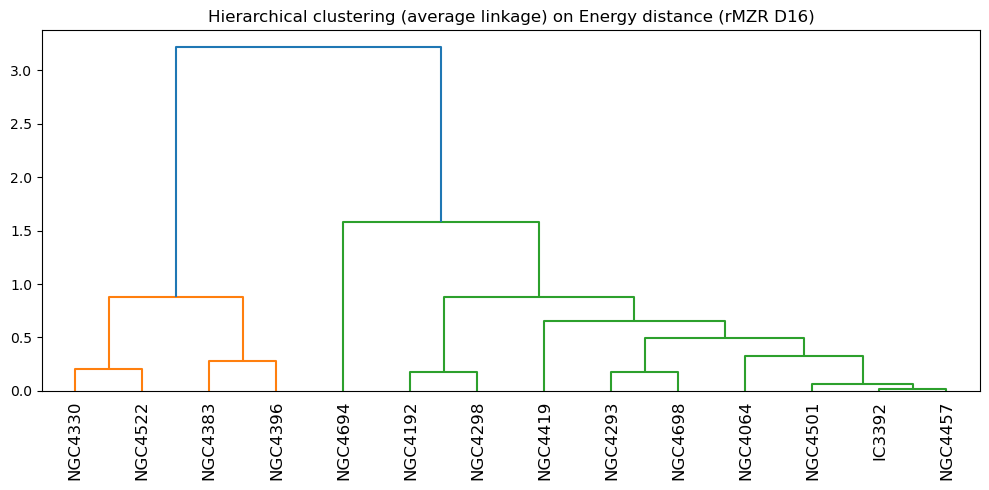

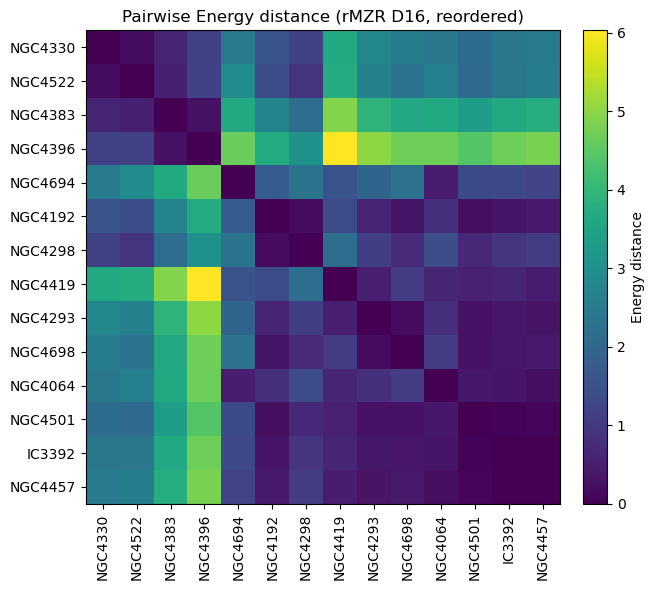

Silhouette by k: {2: np.float64(0.7469184060665739), 3: np.float64(0.5680459994568862), 4: np.float64(0.5136432486694226), 5: np.float64(0.4846477707561338), 6: np.float64(0.4385404441927188), 7: np.float64(0.5425639308222359)}
Best k = 2 with silhouette = 0.747
Cluster 1: ['NGC4330', 'NGC4383', 'NGC4396', 'NGC4522']
Cluster 2: ['IC3392', 'NGC4064', 'NGC4192', 'NGC4293', 'NGC4298', 'NGC4419', 'NGC4457', 'NGC4501', 'NGC4694', 'NGC4698']


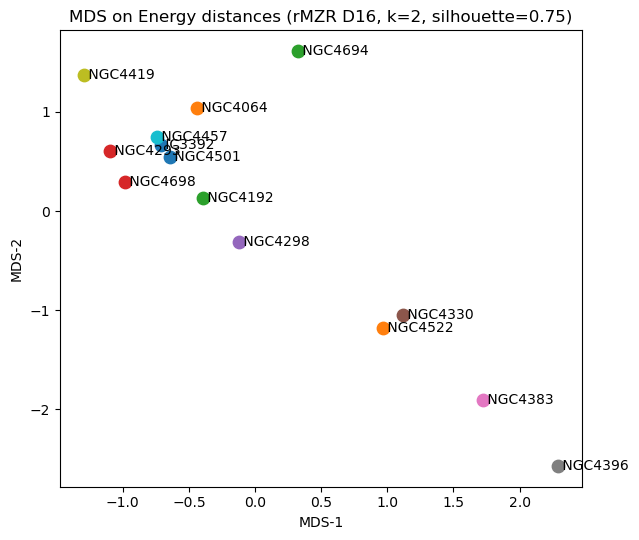

In [4]:
# ==============================================================
# rMZR (D16) distribution clustering via pairwise Energy distances
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# ---------- 1) Prep: collect D16 metallicity per galaxy ----------

def _zscore(X):
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    sd[sd == 0] = 1.0
    return (X - mu) / sd


def collect_groups_for_clustering(
    galaxy_names,
    xlim=(6.0, 11.0),
    ylim=(8.0, 9.2),
    standardize=True,
    max_per_group=2000,
    rng_seed=42
):
    """Return (groups, names) where each group is (n_i,2): [logΣ*, 12+log(O/H)_D16]."""
    rng = np.random.default_rng(rng_seed)
    raw_groups, names = [], []
    for gal in galaxy_names:
        sigM, oh_d16 = load_maps(gal)
        m = np.isfinite(sigM) & np.isfinite(oh_d16)
        if not np.any(m):
            continue
        x, y = sigM[m], oh_d16[m]
        clip = (x >= xlim[0]) & (x <= xlim[1]) & (y >= ylim[0]) & (y <= ylim[1])
        x, y = x[clip], y[clip]
        if x.size == 0:
            continue
        XY = np.column_stack([x, y])
        if XY.shape[0] > max_per_group:
            idx = rng.choice(XY.shape[0], size=max_per_group, replace=False)
            XY = XY[idx]
        raw_groups.append(XY)
        names.append(gal)

    if len(raw_groups) < 2:
        raise ValueError("Need at least two galaxies with usable D16 spaxels.")

    if standardize:
        pooled = np.vstack(raw_groups)
        pooled_z = _zscore(pooled)
        groups, start = [], 0
        for XY in raw_groups:
            n = XY.shape[0]
            groups.append(pooled_z[start:start+n])
            start += n
    else:
        groups = raw_groups

    return groups, names

# If you already have `groups, names`, you can comment this out:
try:
    groups, names  # noqa: F823
except NameError:
    groups, names = collect_groups_for_clustering(
        galaxies,
        xlim=(6.0, 11.0),
        ylim=(8.0, 9.2),
        standardize=True,
        max_per_group=2000,   # raise if you have RAM
        rng_seed=42
    )

# ---------- 2) Pairwise Energy distance (effect size) ----------

def energy_distance_effect(X, Y, dtype=np.float32):
    """
    Classical (two-sample) energy distance:
      D = 2 E||X-Y|| - E||X-X'|| - E||Y-Y'||
    Computed from sample means of pairwise Euclidean distances.
    """
    X = X.astype(dtype, copy=False)
    Y = Y.astype(dtype, copy=False)
    DX = pairwise_distances(X)   # (n,n)
    DY = pairwise_distances(Y)   # (m,m)
    # mean of off-diagonals within groups
    n = DX.shape[0]
    m = DY.shape[0]
    if n > 1:
        exx = (DX.sum() - np.trace(DX)) / (n * (n - 1))
    else:
        exx = 0.0
    if m > 1:
        eyy = (DY.sum() - np.trace(DY)) / (m * (m - 1))
    else:
        eyy = 0.0
    exy = pairwise_distances(X, Y).mean()
    D = 2.0 * exy - exx - eyy
    return max(0.0, float(D))   # clamp tiny negatives due to finite-sample noise


def energy_distance_matrix(groups, names):
    G = len(groups)
    M = np.zeros((G, G), dtype=np.float64)
    for i in range(G):
        for j in range(i+1, G):
            d = energy_distance_effect(groups[i], groups[j])
            M[i, j] = M[j, i] = d
    return M


D_energy = energy_distance_matrix(groups, names)

# ---------- 3) Hierarchical clustering + dendrogram ----------
# Convert to condensed vector for linkage
# Use 'average' (UPGMA) on dissimilarities
Z = linkage(squareform(D_energy), method='average')

# Dendrogram (top)
plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels=names, leaf_rotation=90)
plt.title("Hierarchical clustering (average linkage) on Energy distance (rMZR D16)")
plt.tight_layout()
plt.show()

# Heatmap reordered by dendrogram leaves
order = dn["leaves"]
D_ord = D_energy[np.ix_(order, order)]
labels_ord = [names[i] for i in order]

plt.figure(figsize=(7, 6))
im = plt.imshow(D_ord, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04, label="Energy distance")
plt.xticks(range(len(labels_ord)), labels_ord, rotation=90)
plt.yticks(range(len(labels_ord)), labels_ord)
plt.title("Pairwise Energy distance (rMZR D16, reordered)")
plt.tight_layout()
plt.show()

# ---------- 4) Choose k via silhouette on precomputed distances ----------
best_k, best_sil = None, -1.0
k_grid = range(2, min(8, len(names)))  # try 2..7 (or up to n-1)
sil_by_k = {}

for k in k_grid:
    # cut dendrogram at k clusters
    labels_k = fcluster(Z, k, criterion='maxclust')
    # silhouette on precomputed dissimilarities:
    # sklearn expects 0 on diagonal and symmetric positive values
    sil = silhouette_score(D_energy, labels_k, metric='precomputed')
    sil_by_k[k] = sil
    if sil > best_sil:
        best_sil, best_k = sil, k

print("Silhouette by k:", sil_by_k)
print(f"Best k = {best_k} with silhouette = {best_sil:.3f}")

# Final cluster labels at best_k
labels_best = fcluster(Z, best_k, criterion='maxclust')

# Show clusters
for cl in range(1, best_k+1):
    members = [names[i] for i, lab in enumerate(labels_best) if lab == cl]
    print(f"Cluster {cl}: {members}")

# ---------- 5) MDS map (2D) for a visual embedding ----------
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
XY = mds.fit_transform(D_energy)

plt.figure(figsize=(6.5, 5.5))
for i, nm in enumerate(names):
    plt.scatter(XY[i,0], XY[i,1], s=80)
    plt.text(XY[i,0], XY[i,1], " " + nm, va='center', ha='left')
plt.title(f"MDS on Energy distances (rMZR D16, k={best_k}, silhouette={best_sil:.2f})")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.tight_layout()
plt.show()


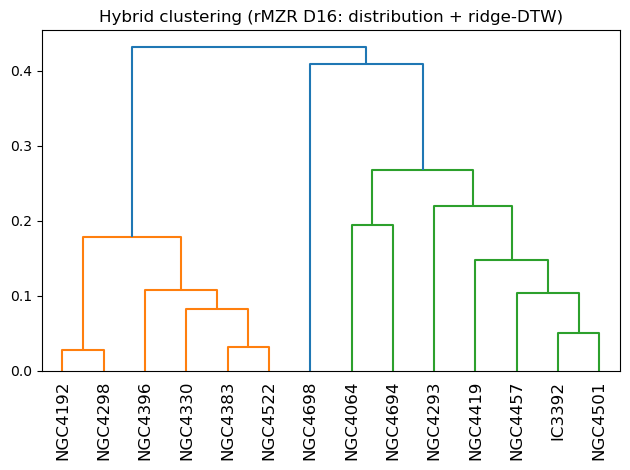

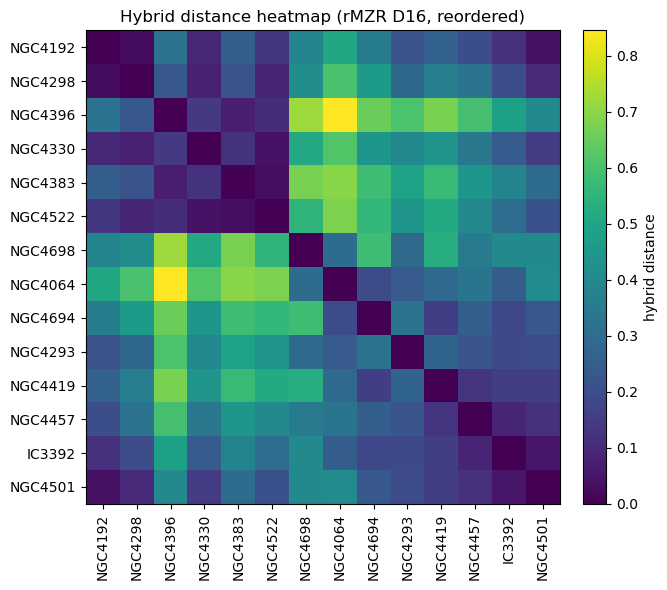

[hybrid rMZR D16] best k=2  silhouette=0.488
Cluster 1: ['NGC4192', 'NGC4298', 'NGC4330', 'NGC4383', 'NGC4396', 'NGC4522']
Cluster 2: ['IC3392', 'NGC4064', 'NGC4293', 'NGC4419', 'NGC4457', 'NGC4501', 'NGC4694', 'NGC4698']


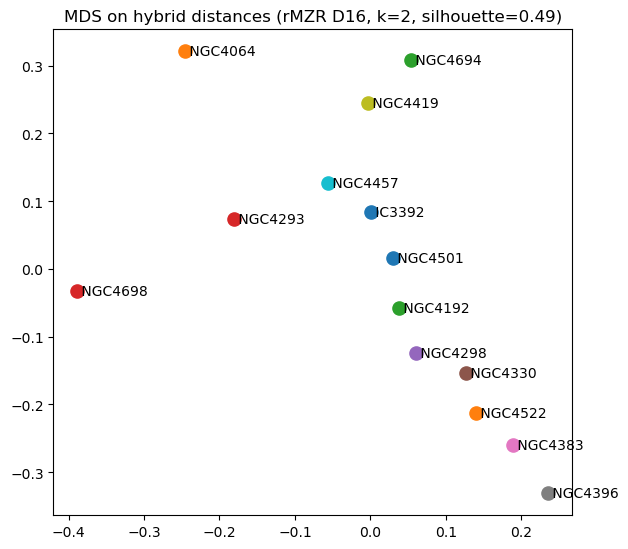

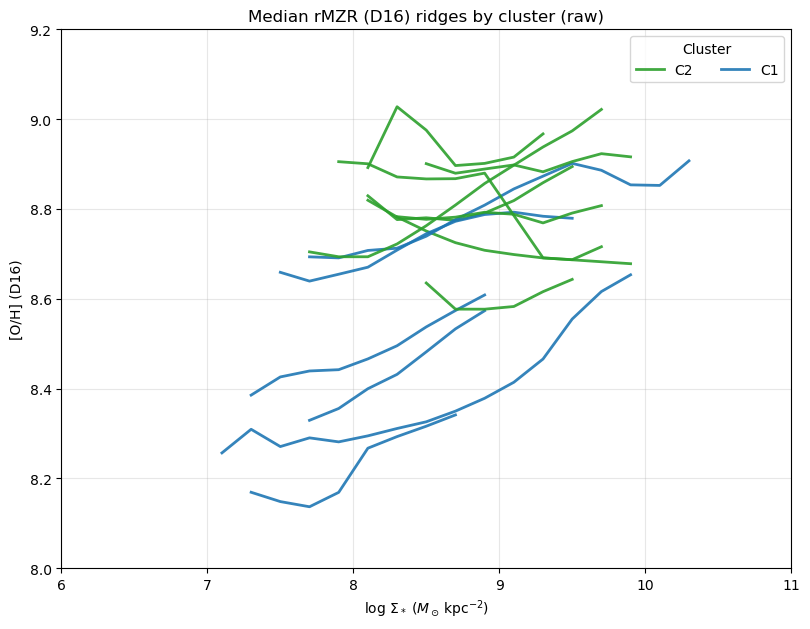

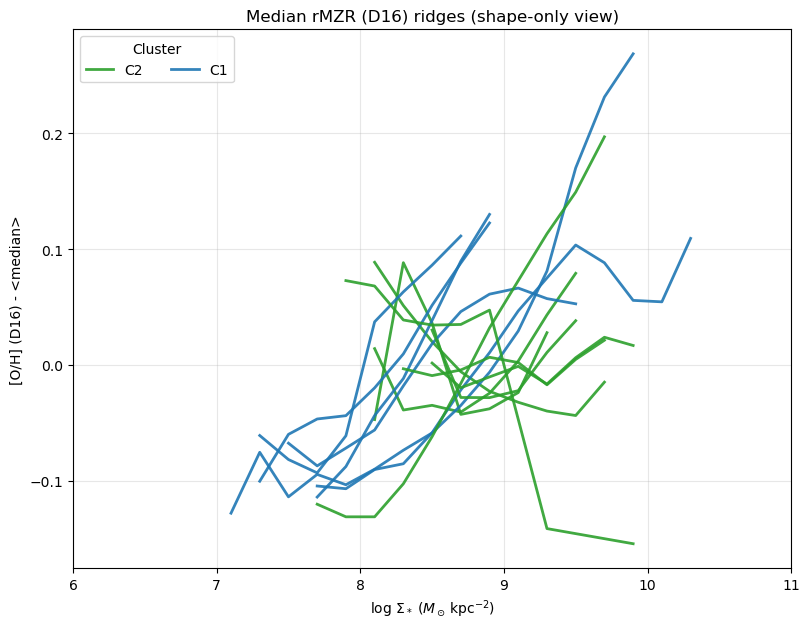

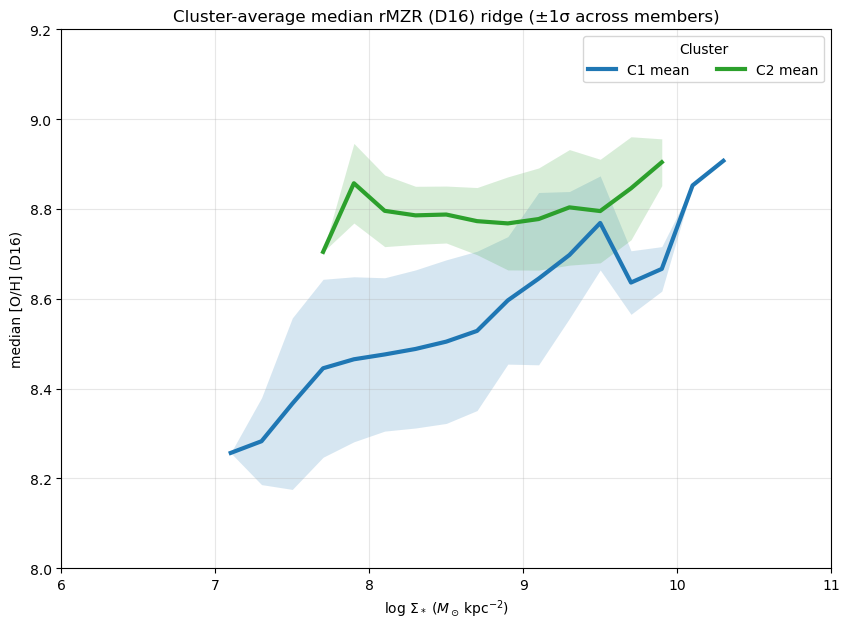

In [5]:
# ========================= HYBRID CLUSTERING (rMZR D16): distribution + ridge-trend =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# ---------- your median function (verbatim) ----------
def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2

    medians, stds, x_valid = [], [], []
    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])
    return np.array(x_valid), np.array(medians), np.array(stds)

# ---------- A) Distribution distance (energy distance on 2D clouds) ----------

def energy_distance_effect(X, Y, dtype=np.float32):
    X = X.astype(dtype, copy=False); Y = Y.astype(dtype, copy=False)
    DX = pairwise_distances(X); np.fill_diagonal(DX, 0.0)
    DY = pairwise_distances(Y); np.fill_diagonal(DY, 0.0)
    n, m = len(X), len(Y)
    exx = (DX.sum() - np.trace(DX)) / (n * (n - 1)) if n > 1 else 0.0
    eyy = (DY.sum() - np.trace(DY)) / (m * (m - 1)) if m > 1 else 0.0
    exy = pairwise_distances(X, Y).mean()
    return max(0.0, 2*exy - exx - eyy)


def collect_point_groups(galaxy_names, x_range=(6,11), y_range=(8.0,9.2), max_per_group=None, seed=42):
    """Collect 2D clouds of [logΣ*, 12+log(O/H)_D16] per galaxy within ranges."""
    rng = np.random.default_rng(seed)
    groups, names = [], []
    for gal in galaxy_names:
        sigM, oh_d16 = load_maps(gal)
        m = np.isfinite(sigM) & np.isfinite(oh_d16)
        x, y = sigM[m], oh_d16[m]
        keep = (x>=x_range[0])&(x<=x_range[1])&(y>=y_range[0])&(y<=y_range[1])
        X = np.column_stack([x[keep], y[keep]])
        if X.size == 0:
            continue
        if (max_per_group is not None) and (len(X) > max_per_group):
            idx = rng.choice(len(X), size=max_per_group, replace=False)
            X = X[idx]
        groups.append(X); names.append(gal)
    return groups, names


def energy_distance_matrix(groups):
    G = len(groups)
    D = np.zeros((G, G))
    for i in range(G):
        for j in range(i+1, G):
            d = energy_distance_effect(groups[i], groups[j])
            D[i,j] = D[j,i] = d
    return D

# ---------- B) Trend-continuity distance (DTW on median ridges; no fitting) ----------

def collect_median_ridges(galaxy_names, x_range=(6,11), y_range=(8.0,9.2), bin_width=0.2):
    """Median ridges of [O/H]_D16 vs logΣ* per galaxy on a common grid."""
    ridges, names = {}, []
    for gal in galaxy_names:
        sigM, oh_d16 = load_maps(gal)
        m = np.isfinite(sigM) & np.isfinite(oh_d16)
        x, y = sigM[m], oh_d16[m]
        keep = (x>=x_range[0])&(x<=x_range[1])&(y>=y_range[0])&(y<=y_range[1])
        x, y = x[keep], y[keep]
        if x.size == 0:
            continue
        xc, yc, sc = calculate_median_statistics(x, y, x_range=x_range, bin_width=bin_width)
        if xc.size == 0:
            continue
        ridges[gal] = {"x": xc, "y": yc, "s": sc}
        names.append(gal)
    return ridges, names


def _standardize_1d(a):
    a = a.astype(float)
    a = a - np.nanmean(a)
    s = np.nanstd(a)
    return a / (s if s>0 else 1.0)


def dtw_distance(seq1, seq2, window=None):
    """
    Simple DTW with L1 cost; returns average path cost so it's length-invariant.
    window: None (full) or integer constraint |i-j|<=window
    """
    a, b = seq1, seq2
    n, m = len(a), len(b)
    if n==0 or m==0:
        return np.inf
    D = np.full((n+1, m+1), np.inf)
    D[0,0] = 0.0
    for i in range(1, n+1):
        j_start = 1 if window is None else max(1, i-window)
        j_end   = m+1 if window is None else min(m+1, i+window+1)
        ai = a[i-1]
        for j in range(j_start, j_end):
            cost = abs(ai - b[j-1])
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
    path_len = n + m
    return float(D[n,m] / path_len)


def dtw_ridge_matrix(ridges, names, allow_offset=True, window=None):
    # sequences of per-galaxy medians; allow_offset=True => standardize per ridge
    seqs = []
    for nm in names:
        y = ridges[nm]["y"].copy()
        seqs.append(_standardize_1d(y) if allow_offset else y.astype(float))
    G = len(names)
    D = np.zeros((G, G))
    for i in range(G):
        for j in range(i+1, G):
            d = dtw_distance(seqs[i], seqs[j], window=window)
            D[i,j] = D[j,i] = d
    return D

# ---------- C) Combine distances & cluster ----------

def _normalize_offdiag(M):
    """Min-max normalize off-diagonal entries to [0,1], keep diag=0."""
    G = M.shape[0]
    mask = ~np.eye(G, dtype=bool)
    vals = M[mask]
    lo, hi = np.nanmin(vals), np.nanmax(vals)
    if hi <= lo:
        N = np.zeros_like(M); return N
    N = (M - lo) / (hi - lo)
    np.fill_diagonal(N, 0.0)
    return N


def hybrid_cluster(galaxy_names,
                   x_range=(6,11), y_range=(8.0,9.2), bin_width=0.2,
                   max_per_group=2000, seed=42,
                   w_dist=0.6, w_trend=0.4, dtw_window=None):
    # A) 2D parameter-space similarity (energy distance)
    groups, namesA = collect_point_groups(galaxy_names, x_range, y_range, max_per_group, seed)
    D1 = energy_distance_matrix(groups)

    # B) “same long trend” continuity (DTW of median ridges)
    ridges, namesB = collect_median_ridges(galaxy_names, x_range, y_range, bin_width)

    # Align order to galaxies present in both
    names = [nm for nm in galaxy_names if (nm in namesA) and (nm in namesB)]
    idxA = [namesA.index(nm) for nm in names]
    D1 = D1[np.ix_(idxA, idxA)]
    D2 = dtw_ridge_matrix(ridges, names, allow_offset=True, window=dtw_window)

    # Combine normalized distances
    D1n, D2n = _normalize_offdiag(D1), _normalize_offdiag(D2)
    D = w_dist*D1n + w_trend*D2n

    # Clustering + k selection
    Z = linkage(squareform(D), method='average')
    dn = dendrogram(Z, labels=names, leaf_rotation=90)
    plt.title("Hybrid clustering (rMZR D16: distribution + ridge-DTW)")
    plt.tight_layout(); plt.show()

    order = dn["leaves"]
    plt.figure(figsize=(7,6))
    im = plt.imshow(D[np.ix_(order, order)], interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04, label="hybrid distance")
    plt.xticks(range(len(order)), [names[i] for i in order], rotation=90)
    plt.yticks(range(len(order)), [names[i] for i in order])
    plt.title("Hybrid distance heatmap (rMZR D16, reordered)")
    plt.tight_layout(); plt.show()

    best_k, best_sil, best_labs = None, -1.0, None
    for k in range(2, min(8, len(names))):
        labs = fcluster(Z, k, criterion='maxclust')
        sil = silhouette_score(D, labs, metric='precomputed')
        if sil > best_sil:
            best_k, best_sil, best_labs = k, sil, labs
    print(f"[hybrid rMZR D16] best k={best_k}  silhouette={best_sil:.3f}")
    for c in range(1, best_k+1):
        members = [names[i] for i,l in enumerate(best_labs) if l==c]
        print(f"Cluster {c}: {members}")

    # MDS map
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
    XY = mds.fit_transform(D)
    plt.figure(figsize=(6.4,5.6))
    for i,nm in enumerate(names):
        plt.scatter(XY[i,0], XY[i,1], s=90)
        plt.text(XY[i,0], XY[i,1], " "+nm, va='center', ha='left')
    plt.title(f"MDS on hybrid distances (rMZR D16, k={best_k}, silhouette={best_sil:.2f})")
    plt.tight_layout(); plt.show()

    return names, ridges, D1, D2, D, best_k, best_labs

# --------------------- RUN: set your prefs here ---------------------
names, ridges, D_dist, D_trend, D_hybrid, k, labels = hybrid_cluster(
    galaxies,
    x_range=(6,11), y_range=(8.0,9.2), bin_width=0.2,
    max_per_group=2000,   # raise if you have RAM; beware O(n^2) in energy distance
    seed=42,
    w_dist=0.6,           # weight for 2D parameter-space similarity
    w_trend=0.4,          # weight for “subtrend of same ridge”
    dtw_window=None       # or an int (e.g., 5) to limit warping (5 bins = 1 dex for bin_width=0.2)
)

# ===================== VISUALIZE HYBRID-CLUSTER TRENDS (rMZR D16) =====================
from collections import defaultdict

x_range = (6, 11)
y_range = (8.0, 9.2)
bin_width = 0.2
label_map = {nm: int(lab) for nm, lab in zip(names, labels)}
clusters = sorted(set(labels))
palette = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

# Ensure ridges have x,y,s for all names (already produced above)
ridges_vis = {nm: ridges[nm] for nm in names if nm in ridges}

# ---------------- Plot 1: RAW median ridges (level + shape) ----------------
plt.figure(figsize=(8.2, 6.4))
seen = set()
for nm in names:
    if nm not in ridges_vis:
        continue
    lab = label_map[nm]
    col = palette[(lab-1) % len(palette)]
    xc, yc = ridges_vis[nm]["x"], ridges_vis[nm]["y"]
    lbl = f"C{lab}" if lab not in seen else None
    seen.add(lab)
    plt.plot(xc, yc, lw=2, alpha=0.9, color=col, label=lbl)

plt.xlim(*x_range); plt.ylim(*y_range); plt.grid(alpha=0.3)
plt.xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$')
plt.ylabel(r'[O/H] (D16)')
plt.title("Median rMZR (D16) ridges by cluster (raw)")
plt.legend(title="Cluster", ncol=3)
plt.tight_layout()
plt.show()

# ------------- Plot 2: SHAPE-ONLY (each ridge mean-subtracted) -------------
plt.figure(figsize=(8.2, 6.4))
seen = set()
for nm in names:
    if nm not in ridges_vis:
        continue
    lab = label_map[nm]
    col = palette[(lab-1) % len(palette)]
    xc, yc = ridges_vis[nm]["x"], ridges_vis[nm]["y"]
    yc_centered = yc - np.nanmean(yc)
    lbl = f"C{lab}" if lab not in seen else None
    seen.add(lab)
    plt.plot(xc, yc_centered, lw=2, alpha=0.9, color=col, label=lbl)

plt.xlim(*x_range); plt.grid(alpha=0.3)
plt.xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$')
plt.ylabel(r'[O/H] (D16) - <median>')
plt.title("Median rMZR (D16) ridges (shape-only view)")
plt.legend(title="Cluster", ncol=3)
plt.tight_layout()
plt.show()

# --------- Plot 3: CLUSTER-AVERAGE ridge (+ 1σ envelope), weighted ---------
xbins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
xcent = 0.5*(xbins[:-1] + xbins[1:])
x_index = {round(xc, 6): i for i, xc in enumerate(xcent)}  # fast alignment

plt.figure(figsize=(8.6, 6.4))
for lab in clusters:
    members = [nm for nm in names if (nm in ridges_vis) and (label_map[nm] == lab)]
    if not members:
        continue
    col = palette[(lab-1) % len(palette)]

    # Stack member medians onto the common x grid with inverse-variance weights
    Y, W = [], []
    for nm in members:
        xc = ridges_vis[nm]["x"]; yc = ridges_vis[nm]["y"]; sc = ridges_vis[nm]["s"]
        yv = np.full_like(xcent, np.nan, dtype=float)
        wv = np.full_like(xcent, np.nan, dtype=float)
        for k, xval in enumerate(xc):
            j = x_index.get(round(xval,6), None)
            if j is not None:
                yv[j] = yc[k]
                wv[j] = 1.0 / (sc[k]**2 + 1e-12)  # inverse-variance
        Y.append(yv); W.append(wv)

    Y = np.vstack(Y); W = np.vstack(W)
    wsum = np.nansum(W, axis=0)
    valid = wsum > 0
    mu = np.full_like(xcent, np.nan, dtype=float)
    mu[valid] = np.nansum(W[:, valid] * Y[:, valid], axis=0) / wsum[valid]

    var = np.full_like(xcent, np.nan, dtype=float)
    if np.any(valid):
        diff = Y[:, valid] - mu[valid]
        var[valid] = np.nansum(W[:, valid] * diff**2, axis=0) / wsum[valid]
    sigma = np.sqrt(var)

    plt.plot(xcent, mu, color=col, lw=3, label=f"C{lab} mean")
    if np.any(valid):
        lo, hi = mu - sigma, mu + sigma
        ok = np.isfinite(lo) & np.isfinite(hi)
        plt.fill_between(xcent, lo, hi, where=ok, color=col, alpha=0.18, linewidth=0)

plt.xlim(*x_range); plt.ylim(*y_range); plt.grid(alpha=0.3)
plt.xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$')
plt.ylabel(r'median [O/H] (D16)')
plt.title("Cluster-average median rMZR (D16) ridge (±1σ across members)")
plt.legend(title="Cluster", ncol=3)
plt.tight_layout()
plt.show()
